In [10]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
solar_flare = fetch_ucirepo(id=89) 
  
# data (as pandas dataframes) 
X = solar_flare.data.features 
y = solar_flare.data.targets 
  
# metadata 
print(solar_flare.metadata) 
  
# variable information 
print(solar_flare.variables) 


{'uci_id': 89, 'name': 'Solar Flare', 'repository_url': 'https://archive.ics.uci.edu/dataset/89/solar+flare', 'data_url': 'https://archive.ics.uci.edu/static/public/89/data.csv', 'abstract': 'Each class attribute counts the number of solar flares of a certain class that occur in a 24 hour period', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1389, 'num_features': 10, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['common flares', 'moderate flares', 'severe flares'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5530G', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Notes:\r\n\r\n   -- The database contains 3 potential classes, one for the number of times a certain type of solar flare occured in a 24 hour period.\r\n   -- Each instance represents captur

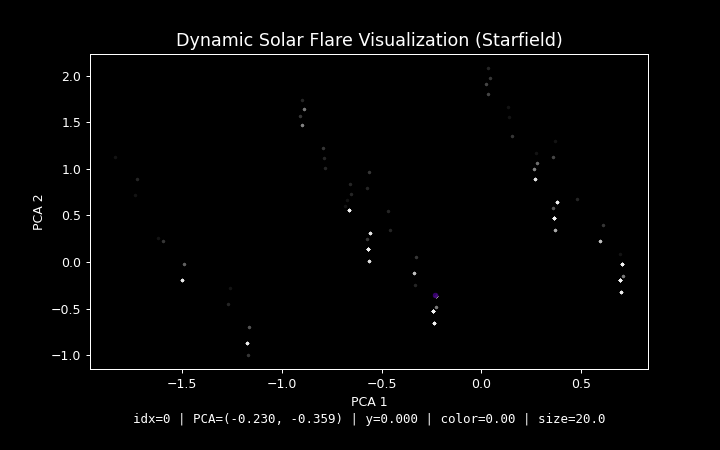

[Fallback] ffmpeg not available, saved GIF instead -> solar_flare.gif


In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from pandas.api.types import is_numeric_dtype
from IPython.display import Image, Video, display
from matplotlib.colors import LinearSegmentedColormap, Normalize

# 1) Clean and align the data
X_num = X.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
if X_num.shape[1] == 0:
    raise ValueError("All feature columns are non-numeric and cannot be visualized.")
X_num = X_num.fillna(X_num.median(numeric_only=True))

if isinstance(y, pd.DataFrame):
    y_series = y.iloc[:, 0]
elif isinstance(y, pd.Series):
    y_series = y
else:
    y_series = pd.Series(y)

if not is_numeric_dtype(y_series):
    y_enc = LabelEncoder().fit_transform(y_series.astype(str))
else:
    y_enc = pd.to_numeric(y_series, errors='coerce').fillna(0).to_numpy()

target_series = pd.Series(y_enc, index=y_series.index, name='target')
aligned = X_num.join(target_series, how='inner')
aligned[X_num.columns] = aligned[X_num.columns].fillna(aligned[X_num.columns].median(numeric_only=True))

X_clean = aligned.drop(columns=['target']).to_numpy()
y_clean = aligned['target'].to_numpy()
if X_clean.shape[0] < 2 or X_clean.shape[1] == 0:
    raise ValueError("Insufficient samples or no features available for animation.")

# 2) PCA -> 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_clean)

# 3) Color and size mapping
size_scaler = MinMaxScaler(feature_range=(20, 120))
color_scaler = MinMaxScaler(feature_range=(0.0, 1.0))
sizes_all = size_scaler.fit_transform(y_clean.reshape(-1, 1)).flatten()
colors_all = color_scaler.fit_transform(y_clean.reshape(-1, 1)).flatten()

N = X_2d.shape[0]
num_frames = int(min(300, N))   # 保守帧数避免内存压力
frame_idx = np.linspace(1, N, num_frames, dtype=int)

# 4) Starfield style
plt.rcParams.update({
    'figure.facecolor': 'black',
    'axes.facecolor': 'black',
    'savefig.facecolor': 'black',
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'axes.edgecolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.titlecolor': 'white',
})
star_cmap = LinearSegmentedColormap.from_list("star", ["#3a0071", "#7a33c8", "#b98cff", "#ffffff"])

fig, ax = plt.subplots(figsize=(8, 5), dpi=90)
# 预留底部空白，给动态读数显示
fig.subplots_adjust(bottom=0.18)

ax.set_title("Dynamic Solar Flare Visualization (Starfield)", fontsize=14)
ax.set_xlabel("PCA 1"); ax.set_ylabel("PCA 2")
for sp in ax.spines.values():
    sp.set_color('white')

x_min, x_max = X_2d[:, 0].min(), X_2d[:, 0].max()
y_min, y_max = X_2d[:, 1].min(), X_2d[:, 1].max()
mx = (x_max - x_min) * 0.05 or 1.0
my = (y_max - y_min) * 0.05 or 1.0
ax.set_xlim(x_min - mx, x_max + mx)
ax.set_ylim(y_min - my, y_max + my)

# Static background
ax.scatter(X_2d[:, 0], X_2d[:, 1], s=8, c='white', alpha=0.08, linewidths=0)

# Foreground sliding window
trail_len = 120
norm01 = Normalize(vmin=0.0, vmax=1.0)
fg = ax.scatter([], [], c=[], s=[], cmap=star_cmap, norm=norm01, alpha=0.95, edgecolors='none')
(traj_line,) = ax.plot([], [], lw=1.0, color='white', alpha=0.65)

# Bottom dynamic numeric readout（画在坐标轴上，参与 blit）
data_text = ax.text(
    0.5, -0.14, "",
    transform=ax.transAxes, ha="center", va="top",
    color="white", fontsize=10, family="monospace",
    clip_on=False
)
data_text.set_animated(True)

def update(frame):
    f = int(frame)
    start = max(0, f - trail_len)
    pts = X_2d[start:f]
    c = colors_all[start:f]
    s = sizes_all[start:f]
    if len(pts) == 0:
        pts = np.empty((0, 2)); c = np.array([]); s = np.array([])

    fg.set_offsets(pts)
    fg.set_array(c)
    fg.set_sizes(s)
    traj_line.set_data(pts[:, 0] if len(pts) else [], pts[:, 1] if len(pts) else [])

    # Dynamic text for latest point
    i = int(np.clip(f - 1, 0, N - 1))
    x_i, y_i = X_2d[i, 0], X_2d[i, 1]
    y_i_val = float(y_clean[i])
    col_i = float(colors_all[i])
    size_i = float(sizes_all[i])
    data_text.set_text(
        f"idx={i} | PCA=({x_i:.3f}, {y_i:.3f}) | y={y_i_val:.3f} | color={col_i:.2f} | size={size_i:.1f}"
    )

    return fg, traj_line, data_text

ani = FuncAnimation(fig, update, frames=frame_idx, interval=60, blit=True, cache_frame_data=False)

# Prefer MP4; fallback to GIF if ffmpeg unavailable (更稳妥，无嵌套 try/except)
mp4_path = "solar_flare.mp4"
if FFMpegWriter.isAvailable():
    writer = FFMpegWriter(
        fps=12,
        codec="libx264",
        bitrate=1800,
        extra_args=["-pix_fmt", "yuv420p"]
    )
    ani.save(mp4_path, writer=writer, dpi=90)
    plt.close(fig)
    display(Video(mp4_path, embed=True))
else:
    gif_path = "solar_flare.gif"
    ani.save(gif_path, writer=PillowWriter(fps=12), dpi=90)
    plt.close(fig)
    display(Image(filename=gif_path))
    print(f"[Fallback] ffmpeg not available, saved GIF instead -> {gif_path}")